In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data_dir = "../data/stations/"
station_filenames_list = [
    filename for filename in os.listdir(path=data_dir)
    if filename!=".DS_Store"
]

In [18]:
len(station_id_array)

230

In [3]:
station_id_array = [
    filename.split("_")[1].split(".")[0]
    for filename in station_filenames_list
]

station_id_array = [
    idx
    for idx in station_id_array
    if idx!="UN"
]

In [4]:
# Load features and targets into features and targets dictionaries, indexed
# by station ID number.
template_dict = {
    test_station_id : None
    for test_station_id in station_id_array
}
features_dict,targets_dict = copy.deepcopy(template_dict), copy.deepcopy(template_dict)
del(template_dict)

for fname in station_filenames_list:
    station_id = fname.split("_")[1].split(".")[0]
    if "data" in fname:
        temp_feats_df = pd.read_csv(
            data_dir+fname,
            index_col="date"
        )
        temp_feats_df.index = pd.to_datetime(temp_feats_df.index, format="%Y-%m-%d %H:%M:%S")
        features_dict[station_id] = temp_feats_df

    if "targets" in fname:
        temp_targs_df = pd.read_csv(
            data_dir+fname,
            index_col="date"
        )
        temp_targs_df.index = pd.to_datetime(temp_targs_df.index, format="%Y-%m-%d %H:%M:%S")
        targets_dict[station_id] = temp_targs_df

# Data sanity check (added 20210223_T)

In [20]:
len(features_dict.keys())

116

In [8]:
print(features_dict.keys())
print(targets_dict.keys())

dict_keys(['23907', '23908', '53960', '53974', '54796', '04994', '53182', '53155', '53154', '54808', '54797', '63849', '53961', '23909', '23906', '94996', '23904', '63850', '54795', '54811', '03761', '54810', '54794', '94995', '63855', '63869', '03758', '53152', '03759', '53968', '63898', '63856', '04140', '53150', '04236', '04222', '04223', '04237', '53151', '22016', '04990', '63858', '04141', '63857', '94079', '12987', '04126', '03054', '54856', '53877', '53139', '53136', '03067', '53878', '64756', '03728', '03072', '53138', '03055', '03733', '64758', '04127', '13301', '63831', '04128', '54937', '94078', '94088', '94077', '94085', '94075', '63828', '92821', '04131', '53927', '04125', '54854', '53926', '04130', '63829', '63826', '93243', '94074', '94060', '94084', '94080', '54903', '26563', '03061', '94645', '94644', '23803', '53131', '03060', '03074', '03048', '03047', '63838', '54902', '94059', '94081', '54933', '04138', '04137', '92827', '03062', '03063', '53132', '03739', '92826',

In [15]:
df = targets_dict["03047"]
df.sum()

sw1005     0
sw1010     0
sw1020     0
sw1050     0
sw1100     0
sw2005     7
sw2010     0
sw2020     0
sw2050     0
sw2100     0
sw3005    29
sw3010     0
sw3020     0
sw3050     0
sw3100     0
dtype: int64

In [16]:
df = features_dict["03047"]
df.sum()

sw1005           643.366
sw1010           935.340
sw1020           938.627
sw1050          1083.068
sw1100           780.996
sw2005           714.662
sw2010           643.431
sw2020           962.192
sw2050           892.408
sw2100           716.234
sw3005           628.636
sw3010           389.874
sw3020           942.413
sw3050          1321.377
sw3100           886.399
p_official       850.200
t_official    413883.471
dtype: float64

# Explore!

In [5]:
scaled_feats_dict = {
    stat_id : None
    for stat_id in station_id_array
    if features_dict[stat_id].shape[1]==15
}
for stat_id in station_id_array:
    df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
    if df_to_scale.shape[1]==15:
        df_to_scale[(df_to_scale == -99999)] = pd.NA
        df_to_scale = df_to_scale.interpolate(method="time", axis=0)
        df_to_scale = df_to_scale.fillna(method="bfill", axis=0)
        scaler = StandardScaler(with_mean=True)
        feats_scaled_array = scaler.fit_transform(df_to_scale)
#         if np.isnan(feats_scaled_array).sum() == 0:
        scaled_feats_dict[stat_id] = copy.deepcopy(feats_scaled_array)
    else:
        continue

t = [stat_tuple[1] for stat_tuple in scaled_feats_dict.items()]
scaled_feats_array = np.concatenate(t, axis=0)

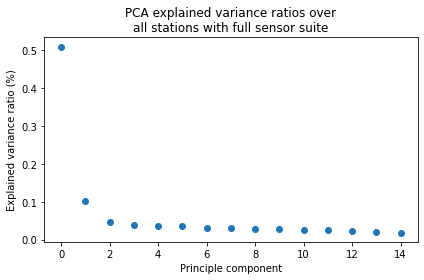

The first 3 explain 0.6561784399135542 of the variance.


In [6]:
pca = PCA()
pca_scaled_feats_array = pca.fit_transform(scaled_feats_array)
evr = pca.explained_variance_ratio_
x = [i for i in range(len(evr))]
plt.scatter(x, evr)
plt.title("PCA explained variance ratios over\nall stations with full sensor suite")
plt.xlabel("Principle component")
plt.ylabel("Explained variance ratio (%)")

plt.tight_layout()
# plt.savefig("../plots/PCA_EVR_allstations_allsensors.png", dpi=300)
plt.show()
num_PC_to_sum = 3
print("The first", num_PC_to_sum, "explain", sum(evr[:num_PC_to_sum]), "of the variance.")

# Concatenate anomaly data for ML

In [7]:
for stat_id in station_id_array:
    df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
    if df_to_scale.shape[1]==15:
        df_to_scale[(df_to_scale == -99999)] = pd.NA
        df_to_scale = df_to_scale.interpolate(method="time", axis=0)
        df_to_scale = df_to_scale.fillna(method="bfill", axis=0)
        scaler = StandardScaler(with_mean=True)
        feats_scaled_array = scaler.fit_transform(df_to_scale)
        feats_scaled_df = pd.DataFrame(data=feats_scaled_array, index=df_to_scale.index, columns=df_to_scale.columns)
#         if np.isnan(feats_scaled_array).sum() == 0:
        scaled_feats_dict[stat_id] = copy.deepcopy(feats_scaled_df)
    else:
        continue

final_station_ids_list = [stat_id for stat_id in scaled_feats_dict.keys()]        

features_dfs_list = [scaled_feats_dict[station_id] for station_id in final_station_ids_list]
targets_dfs_list = [targets_dict[station_id] for station_id in final_station_ids_list]

scaled_feats_df = pd.concat(features_dfs_list, axis=0)
targs_df = pd.concat(targets_dfs_list, axis=0)

In [8]:
combined_scaledfeats_targs_df = pd.concat([scaled_feats_df,targs_df], axis=1)

# This takes a COUPLE MINUTES TO RUN. So, only re-run if necessary!!
# # combined_scaledfeats_targs_df.to_csv("../data/combined_scaledfeats_targs_df.csv")

In [9]:
combined_scaledfeats_targs_NONAN_df = combined_scaledfeats_targs_df.dropna(how="any", axis=0)

In [10]:
# Re-isolate the targets and then combine them into a 1-D pd.series. 
# Whenever a row has at least one anomaly, then we will collapse that row's 
# values to a single value of 1. Rows with no anomalies shall be labeled as 0.
ml_targs_df = combined_scaledfeats_targs_NONAN_df.iloc[:, -15:]
ml_1D_targs_series = ml_targs_df.sum(axis=1)
ml_1D_targs_series[ml_1D_targs_series > 1] = 1

In [11]:
# Re-isolate the ML-ready features.
ml_feats_df = combined_scaledfeats_targs_NONAN_df.iloc[:, :15]

### Calculate the percentage of the ML-ready data that are anomalies

In [12]:
percentage_anomalies =\
    np.round(100*ml_1D_targs_series.sum()/ml_1D_targs_series.shape[0], 2)
print(f"{percentage_anomalies}% of the data are anomalies.")

14.19% of the data are anomalies.


# Attempt some ML! Yewwwwww!

In [13]:
import seaborn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [14]:
X = ml_feats_df.values
y = ml_1D_targs_series.values

# Initialize a random forest (RF) classifier object with the best hyperparameter 
# sets from the grid search.
rf_classifier = RandomForestClassifier(n_jobs=-1)

# Initialize a stratified 5-fold cross-validation object.  Make certain that it
# randomly shuffles the data. AND, since it's randomly shuffling the data, make
# certain that its random state is set to 7 (an arbitrary choice: it simply
# needs to have a constant random state seed).
stratified_kfold_generator = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=7
)

# Iterate through each of the splits and train/test both classifiers. We will 
# store the predictions in the following lists, "classfication predictions_rf" 
# and "classfication predictions_xgb".
classification_predictions_rf = list()
for idx, (train, test) in enumerate(stratified_kfold_generator.split(X, y)):
    
    print(idx)
    
    # Fit the classifiers to the training data. This erases the training from any
    # previous iteration of the loop.
    rf_classifier.fit(X[train], y[train].ravel())

    # Have the newly trained classifiers predict the classes of the withheld testing data.
    y_predicted_rf = rf_classifier.predict(X[test])

    # Add the true class labels and the predicted class labels to the storage lists.
    classification_predictions_rf.append((y[test].ravel(), y_predicted_rf.ravel()))

0
1
2
3
4


/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


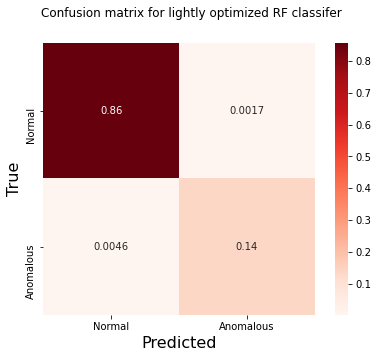

In [15]:
def calculate_normalized_conf_matrix(classification_predictions):
    cf = np.zeros((2,2))
    for y_true, y_pred in classification_predictions:
        cf += confusion_matrix(y_true, y_pred)
    return cf/cf.sum()

class_labels_list = ["Normal", "Anomalous"]

# Loop through the cached predictions and calculate the confusion matrices for
# both classifiers.
cf_rf = calculate_normalized_conf_matrix(classification_predictions_rf)

# Initialize figure and axes objects in order to plot the two confusion matrices.
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot the random forest confusion matrix.
seaborn.heatmap(
    cf_rf, cmap="Reds", annot=cf_rf, square=True, cbar=True,
    xticklabels=class_labels_list, yticklabels=class_labels_list,
    ax=ax
)

# Add labels to the x-axis and the y-axis.
ax.set_xlabel("Predicted", fontsize=16)
ax.set_ylabel("True", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrix for lightly optimized RF classifer")

plt.savefig("randomforest_confusion_matrix.png", dpi=300)

# Display the figure.
fig.show()

In [16]:
cf_rf
# array([[0.85638247, 0.00170387],
#        [0.00459136, 0.1373223 ]])


array([[0.85641194, 0.0016744 ],
       [0.00456731, 0.13734636]])

In [37]:
0.00459136/0.1373223

0.033434919164622205